VAE example from http://nbviewer.jupyter.org/github/tfolkman/deep-learning-experiments/blob/master/VAE.ipynb

In [1]:
%matplotlib inline

import torch

from torch.autograd import Variable
from torch.nn.init import xavier_normal

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [2]:
BATCH_SIZE = 128

transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Processing...
Done!


# Define VAE

In [3]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size=500, coding_size=20):
        super(VAE, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2_mean = nn.Linear(hidden_size, coding_size)
        self.hidden2_gamma = nn.Linear(hidden_size, coding_size)
        self.hidden3 = nn.Linear(coding_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def encoder(self, x):
        hidden1_output = self.relu(self.hidden1(x))
        return self.hidden2_mean(hidden1_output), self.hidden2_gamma(hidden1_output)

    def reparameterize(self, mu, logvar):
        if self.training:
            noise = Variable(logvar.data.new(logvar.size()).normal_())
            return mu + torch.exp(0.5 * logvar) * noise
        else:
            return mu
    
    def decoder(self, x):
        output_value = self.relu(self.hidden3(x))
        output_value = self.output(output_value)
        return output_value, self.sigmoid(output_value)
            
    def forward(self, x):
        mean, gamma = self.encoder(x)
        z = self.reparameterize(mean, gamma)
        output, output_sigmoid = self.decoder(z)
        return output, output_sigmoid, mean, gamma

# Initialise VAE

In [4]:
vae = VAE(input_size=28*28)

# Define loss and optimizer

In [5]:
def custom_loss(recon_x, x, mu, logvar):
    ce_loss = F.binary_cross_entropy_with_logits(recon_x, x,
                                                size_average=False)
    latent_loss = 0.5 * torch.sum(torch.exp(logvar) + mu.pow(2) - 1 - logvar)
    return ce_loss + latent_loss

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [6]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Define training

In [7]:
N_EPOCHS = 100
total_loss = 0
print_every = 70000 // BATCH_SIZE
plot_every = 7000 // BATCH_SIZE
all_losses = []
iter = 1

start = time.time()
vae.train()

VAE(
  (hidden1): Linear(in_features=784, out_features=500, bias=True)
  (hidden2_mean): Linear(in_features=500, out_features=20, bias=True)
  (hidden2_gamma): Linear(in_features=500, out_features=20, bias=True)
  (hidden3): Linear(in_features=20, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=784, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [8]:
for e in range(N_EPOCHS):
    for i_batch, batch in enumerate(trainloader):
        image = batch[0]
        label = batch[1]
        image = Variable(image.view(-1, 1, 28*28))
        
        vae.zero_grad()
        output, output_sigmoid, mean, gamma = vae(image)
        loss = custom_loss(output, image, mean, gamma)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(trainloader) * N_EPOCHS) * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / (plot_every*BATCH_SIZE))
            total_loss = 0
        
        iter = iter + 1

/home/fabsta/.conda/envs/fastai_dl_course/lib/python3.7/site-packages/torch/nn/functional.py:58: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0m 25s (546 1%) 15269.2539
0m 36s (1092 2%) 14437.4395
0m 47s (1638 3%) 14048.8662
0m 57s (2184 4%) 14235.4707
1m 8s (2730 5%) 13368.3301
1m 19s (3276 6%) 13637.4307
1m 30s (3822 8%) 13815.1416
1m 40s (4368 9%) 13853.8809
1m 51s (4914 10%) 13001.4688
2m 2s (5460 11%) 13694.0293
2m 13s (6006 12%) 13296.3994
2m 24s (6552 13%) 13520.2021
2m 35s (7098 15%) 13545.6982
2m 46s (7644 16%) 13454.8125
2m 57s (8190 17%) 12905.6768
3m 8s (8736 18%) 13633.3945
3m 19s (9282 19%) 13280.7109
3m 29s (9828 20%) 13274.9941
3m 40s (10374 22%) 13113.3135
3m 51s (10920 23%) 13228.1797
4m 2s (11466 24%) 12684.0703
4m 12s (12012 25%) 12843.2549
4m 22s (12558 26%) 13085.2158
4m 32s (13104 27%) 13038.3633
4m 43s (13650 29%) 12847.1445
4m 53s (14196 30%) 13381.4199
5m 4s (14742 31%) 13464.0566
5m 15s (15288 32%) 12472.3154
5m 26s (15834 33%) 12848.9590
5m 36s (16380 34%) 13255.2559
5m 47s (16926 36%) 13264.9082
5m 58s (17472 37%) 12780.8428
6m 8s (18018 38%) 13237.7725
6m 19s (18564 39%) 13106.8027
6m 31s (19110

# Evaluation

## Plot losses over time

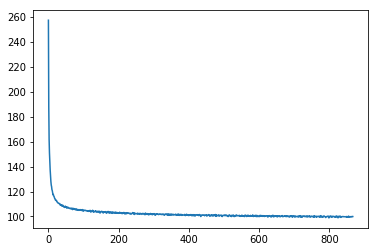

In [9]:
plt.plot(all_losses)

## Visualize features

In [11]:
# get weights of first hiddenlayer
hidden1_weights = vae.hidden1.weight.data.cpu().numpy(); len(hidden1_weights)

500

### Plot example of hidden layer

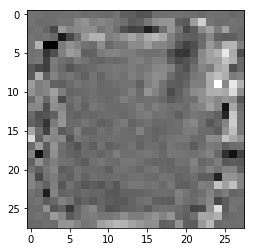

In [13]:
neuron = 0
t = plt.imshow(hidden1_weights[neuron].reshape([28,28]),
           cmap='Greys')

## Decode some images

In [14]:
# Set module to evaluation mode
vae.eval()

VAE(
  (hidden1): Linear(in_features=784, out_features=500, bias=True)
  (hidden2_mean): Linear(in_features=500, out_features=20, bias=True)
  (hidden2_gamma): Linear(in_features=500, out_features=20, bias=True)
  (hidden3): Linear(in_features=20, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=784, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

### Get a random latent picture

In [25]:
random = Variable(torch.randn(64, 20)); random

tensor([[-0.4203, -1.5823, -0.3269,  ...,  0.6304,  1.4745,  1.1985],
        [ 0.7014, -1.8297,  0.3869,  ..., -0.0932, -0.7030,  1.2169],
        [ 0.9258,  0.4230, -0.1321,  ..., -1.1031, -0.1786,  1.1051],
        ...,
        [-1.1285, -0.0698, -0.1914,  ...,  0.6628,  1.5459,  0.3572],
        [ 0.1123,  0.9547, -0.5785,  ...,  0.5735, -2.3425, -1.6576],
        [ 0.1720, -0.0570, -1.2623,  ...,  0.7850,  0.2044, -1.7544]])

### Decode latent picture

In [26]:
_, sample = vae.decoder(random); sample

tensor([[1.2038e-18, 8.5448e-19, 1.6126e-18,  ..., 9.0866e-19, 6.6774e-19,
         7.0448e-19],
        [8.1358e-13, 7.8337e-13, 9.6190e-13,  ..., 8.9767e-13, 8.0653e-13,
         1.0135e-12],
        [1.3498e-11, 1.6749e-11, 1.3110e-11,  ..., 1.7196e-11, 1.3176e-11,
         1.2583e-11],
        ...,
        [2.9012e-20, 2.3414e-20, 2.1238e-20,  ..., 1.5733e-20, 2.1524e-20,
         1.9940e-20],
        [1.7380e-17, 1.7051e-17, 2.1548e-17,  ..., 2.9646e-17, 1.3942e-17,
         2.8922e-17],
        [2.2674e-17, 1.1967e-17, 2.0827e-17,  ..., 2.0226e-17, 1.8480e-17,
         1.4190e-17]], grad_fn=<SigmoidBackward>)

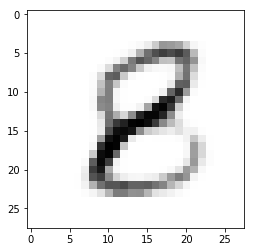

In [27]:
t = plt.imshow(sample[58].data.numpy().reshape(28,28),cmap="Greys")